<a href="https://colab.research.google.com/github/MariiaKalinina/Skoltech/blob/main/RPM_lecture_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [8]:
import numpy as np
from math import *
import pandas as pd

import cv2
from google.colab.patches import cv2_imshow

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.font_manager as font_manager
%matplotlib inline
csfont = {'fontname':'Times New Roman'}

# Functioins

In [2]:
def Likhteneker(phi, lam):
    """
    Calculate the thermal conductivity using the Likhteneker model.

    Parameters:
    phi (list or np.ndarray): Volume fractions of the constituents.
    lam (list or np.ndarray): Thermal conductivities of the constituents.

    Returns:
    float: The effective thermal conductivity based on the Likhteneker model.
    """
    # Using a list comprehension for clarity and performance
    sums = phi * np.log(lam)
    L_likht = np.exp(np.sum(sums))
    return L_likht


def upper_winner(phi, lam):
    """
    Calculate the upper bound of the thermal conductivity using the Upper Wiener model.

    Parameters:
    phi (list or np.ndarray): Volume fractions of the constituents.
    lam (list or np.ndarray): Thermal conductivities of the constituents.

    Returns:
    float: The upper bound thermal conductivity based on the Upper Wiener model.
    """
    # Ensure phi and lam are numpy arrays for element-wise multiplication
    phi = np.array(phi)
    lam = np.array(lam)

    # Using a vectorized approach to calculate the sum
    sums = phi * lam
    return np.sum(sums)


def lower_winner(phi, lam):
    """
    Calculate the lower bound of the thermal conductivity using the Lower Wiener model.

    Parameters:
    phi (list or np.ndarray): Volume fractions of the constituents.
    lam (list or np.ndarray): Thermal conductivities of the constituents.

    Returns:
    float: The lower bound thermal conductivity based on the Lower Wiener model.
    """
    # Using a vectorized approach to calculate the sum and applying the inverse
    phi = np.array(phi)
    lam = np.array(lam)

    sums = phi / lam
    Lo_W = np.sum(sums)
    return 1 / Lo_W  # Take the inverse of the sum


def Average_Winner(phi, lam):
    """
    Calculate the average of the Upper and Lower Wiener models.

    Parameters:
    phi (list or np.ndarray): Volume fractions of the constituents.
    lam (list or np.ndarray): Thermal conductivities of the constituents.

    Returns:
    float: The average thermal conductivity based on the Wiener models.
    """
    return np.mean([upper_winner(phi, lam), lower_winner(phi, lam)])


def Upper_Hashin_Strikman(phi, lam):
    """
    Calculate the upper bound of the thermal conductivity using the Hashin-Strikman model.

    Parameters:
    phi (list or np.ndarray): Volume fractions of the constituents.
    lam (list or np.ndarray): Thermal conductivities of the constituents.

    Returns:
    float: The upper bound thermal conductivity based on the Hashin-Strikman model.
    """
    L0 = np.max(lam)  # Maximum thermal conductivity for comparison body
    f = 1 / 3  # Fraction parameter for the Hashin-Strikman model
    HS_comp1, HS_comp2 = [], []

    for i, j in zip(phi, lam):
        term_c3 = i * j / (L0 * (1 - f) + j * f)
        term_z3 = i / (L0 * (1 - f) + j * f)

        term_c12 = i * j / (L0 * (1 + f) / 2 + j * (1 - f) / 2)
        term_z12 = i / (L0 * (1 + f) / 2 + j * (1 - f) / 2)

        # Calculate the components for parallel and perpendicular directions
        HS_comp1.append((term_c3 + 2 * term_c12) / 3)
        HS_comp2.append((term_z3 + 2 * term_z12) / 3)

    # Sum up the components and compute the effective thermal conductivity
    L_eff = np.sum(HS_comp1) / np.sum(HS_comp2)
    return L_eff


def Lower_Hashin_Strikman(phi, lam):
    """
    Calculate the lower bound of the thermal conductivity using the Hashin-Strikman model.

    Parameters:
    phi (list or np.ndarray): Volume fractions of the constituents.
    lam (list or np.ndarray): Thermal conductivities of the constituents.

    Returns:
    float: The lower bound thermal conductivity based on the Hashin-Strikman model.
    """
    L0 = np.min(lam)  # Minimum thermal conductivity for comparison body
    f = 1 / 3  # Fraction parameter for the Hashin-Strikman model
    HS_comp1, HS_comp2 = [], []

    for i, j in zip(phi, lam):
        term_c3 = i * j / (L0 * (1 - f) + j * f)
        term_z3 = i / (L0 * (1 - f) + j * f)

        term_c12 = i * j / (L0 * (1 + f) / 2 + j * (1 - f) / 2)
        term_z12 = i / (L0 * (1 + f) / 2 + j * (1 - f) / 2)

        # Calculate the components for parallel and perpendicular directions
        HS_comp1.append((term_c3 + 2 * term_c12) / 3)
        HS_comp2.append((term_z3 + 2 * term_z12) / 3)

    # Sum up the components and compute the effective thermal conductivity
    L_eff = np.sum(HS_comp1) / np.sum(HS_comp2)
    return L_eff


def Average_Hashin_Strikman(phi, lam):
    """
    Calculate the average of the Upper and Lower Hashin-Strikman models.

    Parameters:
    phi (list or np.ndarray): Volume fractions of the constituents.
    lam (list or np.ndarray): Thermal conductivities of the constituents.

    Returns:
    float: The average thermal conductivity based on the Hashin-Strikman models.
    """
    return np.mean([Lower_Hashin_Strikman(phi, lam), Upper_Hashin_Strikman(phi, lam)])


In [9]:
def effective_tc(conc, alpha_shape, lam):
    """
    Calculate the effective thermal conductivity using the depolarization factor and Hashin-Strikman-like model.

    Parameters:
    conc (list or np.ndarray): Volume concentrations of the constituents.
    alpha_shape (list or np.ndarray): Aspect ratios of the ellipsoidal inclusions.
    lam (list or np.ndarray): Thermal conductivities of the constituents (including the comparison body).

    Returns:
    float: The effective thermal conductivity.
    """
    #------------------- Depolarization Factor Calculation -------------------
    def depolarization(alpha):
        """
        Calculate the depolarization factor for a given aspect ratio.

        Parameters:
        alpha (float): Aspect ratio of the ellipsoid.

        Returns:
        float: Depolarization factor based on the aspect ratio.
        """
        if alpha < 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(t2 - 1)
            t5 = np.arctan(t4)
            t8 = t4 ** 2
            return t2 * (t4 - t5) / (t8 * t4)
        elif alpha > 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(1 - t2)
            t6 = np.log(1 + t4)
            t9 = np.log(1 - t4)
            t13 = t4 ** 2
            return t2 * (t6 / 2 - t9 / 2 - t4) / (t13 * t4)
        elif alpha == 1:
            return 1 / 3

    # Vectorizing the depolarization calculation for all alpha values
    depolar_F = np.array([depolarization(alpha) for alpha in alpha_shape])

    L0 = lam[0]  # Assuming the first value in lam is the comparison body's thermal conductivity

    def raschet(L0):
        """
        Compute the effective thermal conductivity using a Hashin-Strikman-like model.

        Parameters:
        L0 (float): Thermal conductivity of the comparison body.

        Returns:
        float: The effective thermal conductivity.
        """
        # Initialize parallel and perpendicular components of the thermal conductivity
        parall_comp = []
        perpen_comp = []

        # Loop over the constituents and compute the components
        for i, j, f in zip(conc, lam, depolar_F):
            termc_3 = i * j / (L0 * (1 - f) + j * f)
            termz_3 = i / (L0 * (1 - f) + j * f)

            termc_12 = i * j / (L0 * (1 + f) / 2 + j * (1 - f) / 2)
            termz_12 = i / (L0 * (1 + f) / 2 + j * (1 - f) / 2)

            termc_all = (termc_3 + 2 * termc_12) / 3
            termz_all = (termz_3 + 2 * termz_12) / 3

            parall_comp.append(termc_all)  # Parallel component
            perpen_comp.append(termz_all)  # Perpendicular component

        # Calculate effective thermal conductivity
        L_eff = np.sum(parall_comp) / np.sum(perpen_comp)
        return L_eff

    # Initialize the iteration process
    x0 = L0
    L0 = raschet(x0)

    # Iterate until the change in L0 is smaller than the tolerance
    it_f = 1
    tolerance = 1e-6
    while abs(x0 - L0) >= tolerance:
        x0 = L0
        L0 = raschet(x0)
        it_f += 1

    return L0

In [10]:
output_file = '/content/RP_DATA.xlsx'
path_to_ser = Path(output_file)
data_initial = pd.read_excel(path_to_ser, sheet_name='well-logging', skiprows=0)
data = data_initial.copy()

In [11]:
# Assuming interpolated_df_new is already defined and contains the 'Porosity' column
tc_array_new = []
porosity_list = data['Porosity'].dropna().tolist()

# Generate tc values and add noise
for x in porosity_list:
    tc = 2.98 * np.exp(-2.80 * x)  # Calculate tc based on porosity
    noise = np.random.normal(0, 0.2)  # Generate a single noise value
    y_noisy = tc + noise  # Add noise to the tc value
    tc_array_new.append(y_noisy)  # Append the noisy value to the list

In [12]:
new_data = pd.DataFrame()
new_data['Depth'] = data['Depth porosity'].dropna()
new_data['Porosity'] = data['Porosity']
new_data['TC'] = tc_array_new

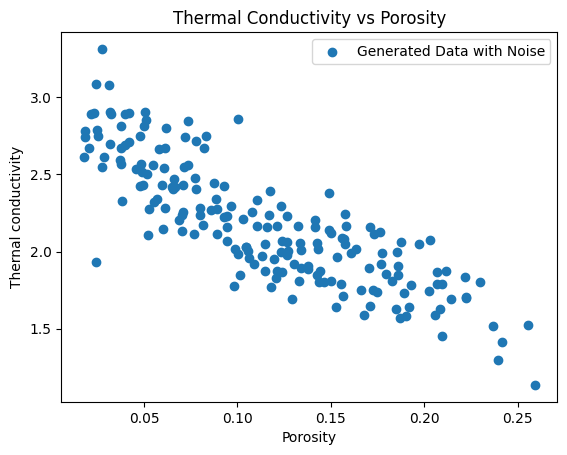

In [16]:
x = new_data['Porosity'].tolist()
y = new_data['TC'].tolist()
plt.scatter(x, y, label='Generated Data with Noise')
plt.xlabel('Porosity')
plt.ylabel('Thernal conductivity')
plt.legend()
plt.title('Thermal Conductivity vs Porosity')
plt.show()

### Winner & Hashin-Strikman bounds

Winner

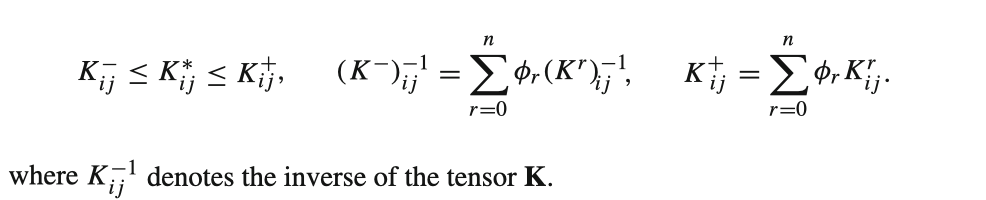

In [ ]:
cv2_imshow(cv2.imread('/content/Winner.png'))

Hashin-Shtrikman bounds

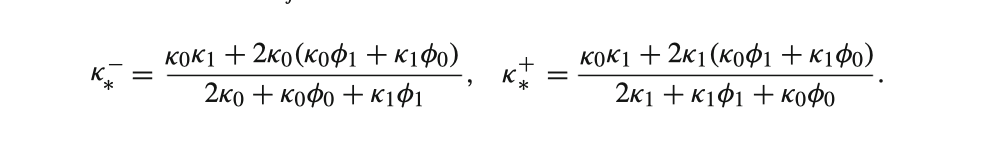

In [ ]:
cv2_imshow(cv2.imread('/content/HS.png'))

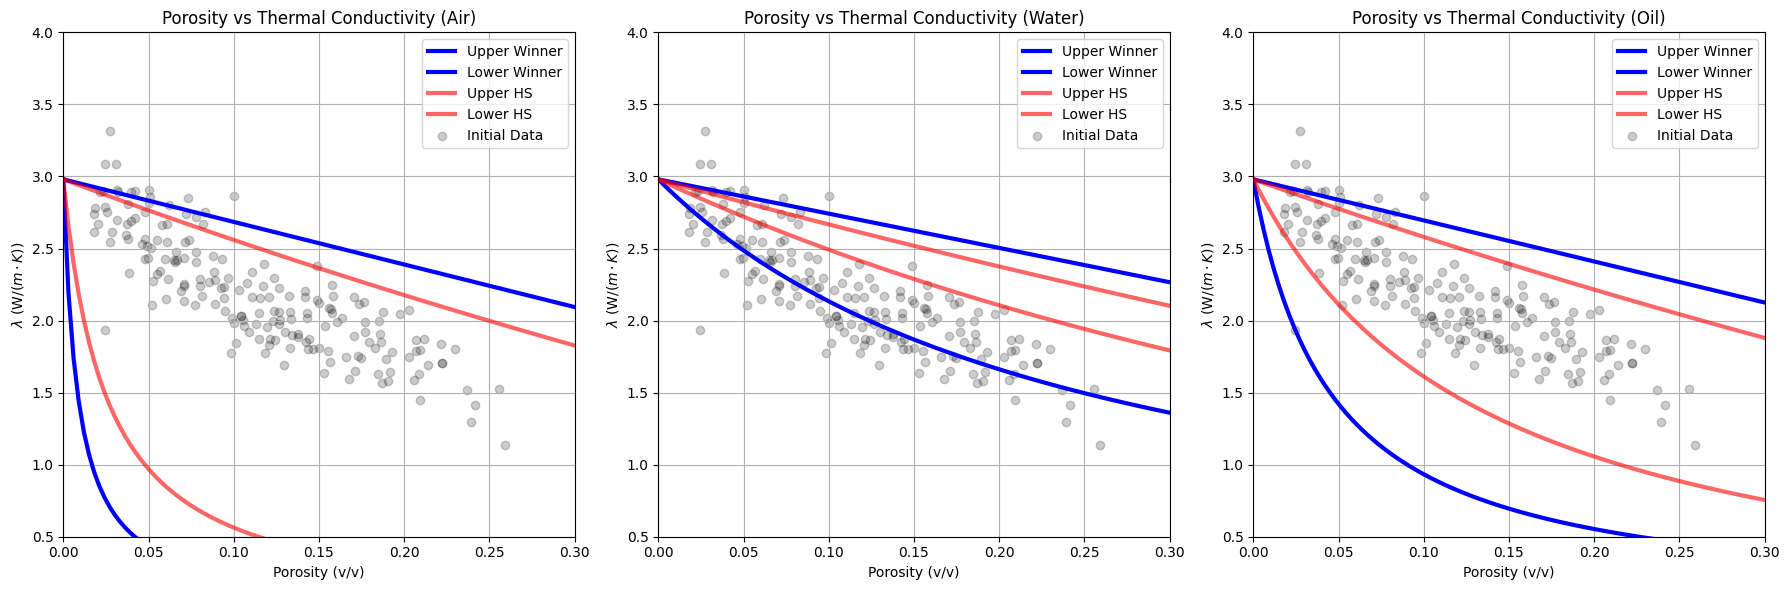

In [17]:
lam_matrix = 2.98
fluid_saturations = {
    'Air': 0.025,
    'Water': 0.60,
    'Oil': 0.13
}

porosity = np.linspace(0, 0.30, 100)

fig, axs = plt.subplots(1, len(fluid_saturations), figsize=(18, 6))

for ax, (fluid_name, lam_fluid) in zip(axs, fluid_saturations.items()):
    lam = [lam_matrix, lam_fluid]

    tc_wn_up, tc_wn_dw = [], []
    tc_hs_up, tc_hs_dw = [], []

    for i in porosity:
        conc = [1 - i, i]
        tc_wn_up.append(upper_winner(conc, lam))
        tc_wn_dw.append(lower_winner(conc, lam))

        tc_hs_up.append(Upper_Hashin_Strikman(conc, lam))
        tc_hs_dw.append(Lower_Hashin_Strikman(conc, lam))

    # Plotting Upper and Lower Winner models
    ax.plot(porosity, tc_wn_up, label='Upper Winner', color='blue', lw=3)
    ax.plot(porosity, tc_wn_dw, label='Lower Winner', color='blue', lw=3)

    # Plotting Upper and Lower Hashin-Strikman models
    ax.plot(porosity, tc_hs_up, color='red', lw=3, alpha=0.6, label='Upper HS')
    ax.plot(porosity, tc_hs_dw, color='red', lw=3, alpha=0.6, label='Lower HS')

    x = new_data['Porosity'].tolist()
    y = new_data['TC'].tolist()

    ax.scatter(x, y, label='Initial Data', color='black', alpha=0.2)

    ax.set_xlabel('Porosity (v/v)')
    ax.set_ylabel("$\lambda$ (W/(${m}\cdot{K}$))")
    ax.set_title(f'Porosity vs Thermal Conductivity ({fluid_name})')
    ax.grid()
    ax.legend()
    ax.set_xlim(porosity.min(), porosity.max())
    ax.set_ylim(0.5, 4)

plt.tight_layout()
plt.show()

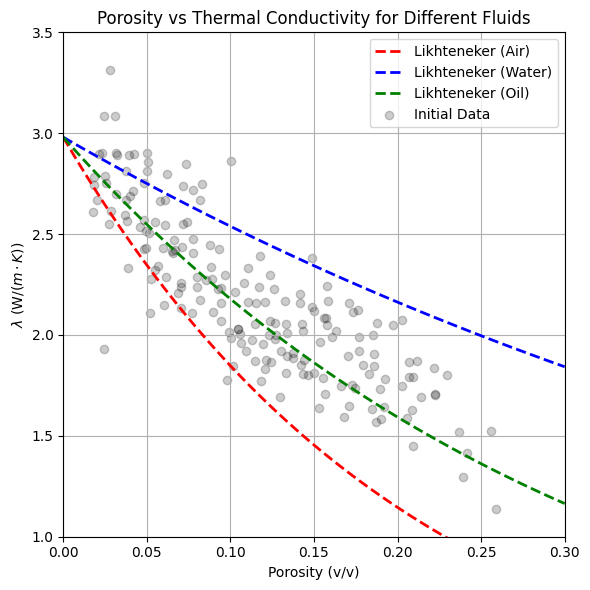

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))

fluid_colors = {
    'Air': 'red',
    'Water': 'blue',
    'Oil': 'green'
}

for fluid_name, lam_fluid in fluid_saturations.items():
    lam = [lam_matrix, lam_fluid]

    tc_likh = []

    for i in porosity:
        conc = [1 - i, i]
        tc_likh.append(Likhteneker(conc, lam))

    ax.plot(porosity, tc_likh, label=f'Likhteneker ({fluid_name})', color=fluid_colors[fluid_name], lw=2, linestyle='--')

    x = new_data['Porosity'].tolist()
    y = new_data['TC'].tolist()


ax.scatter(x, y, label='Initial Data', color='black', alpha=0.2)

ax.set_xlabel('Porosity (v/v)')
ax.set_ylabel("$\lambda$ (W/(${m}\cdot{K}$))")
ax.set_title('Porosity vs Thermal Conductivity for Different Fluids')

ax.grid()
ax.legend()
ax.set_xlim(porosity.min(), porosity.max())
ax.set_ylim(1, 3.5)

plt.tight_layout()
plt.show()

# Effective medium theory (GSA, isotropic)

## Thermal conductivity

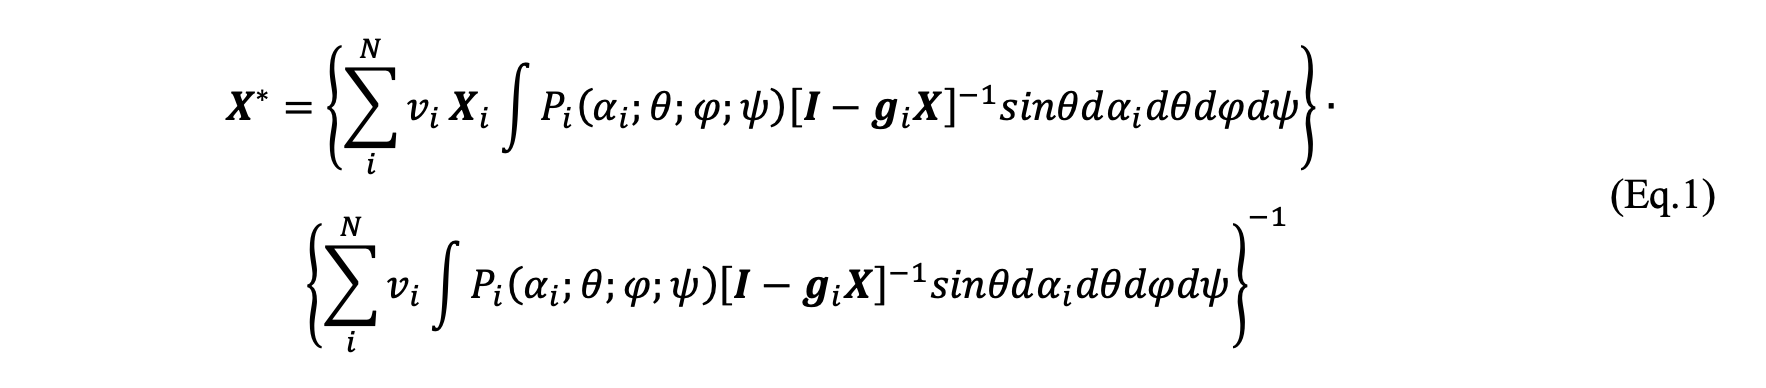

In [ ]:
cv2_imshow(cv2.imread('/content/GSA_1.png'))

Here the outer brackets represent volume averaging, which is performed over all components using their volume concentrations.

$( N )$ is the number of the model’s constituents.

$X^*$ is the fourth-rank tensor for the elastic properties and the second-rank tensor for the transport properties. $X$ is the difference between $X_i$ and $X_C$, where $X_i$ is the tensor of physical properties of the $i$-th constituent, and $X_C$ is the respective properties of the so-called comparison body.

$I$ is the identity tensor of the fourth rank (for elasticity) or second rank (for transport properties). $v_i$ is the volume concentration of the $i$-th constituent.

$P_i$ is the probability density function of the $i$-th constituent in shape and orientation. The shape of the constituent is described by a quantitative parameter known as the aspect ratio of ellipsoids of revolution $\alpha$. The orientation of the constituent is described by the Euler angles $(\theta, \phi, \psi)$, while tensor $g_i$ is controlled by the aspect ratio and comparison body properties.


The tensor $g_i$ for transport properties has the form:

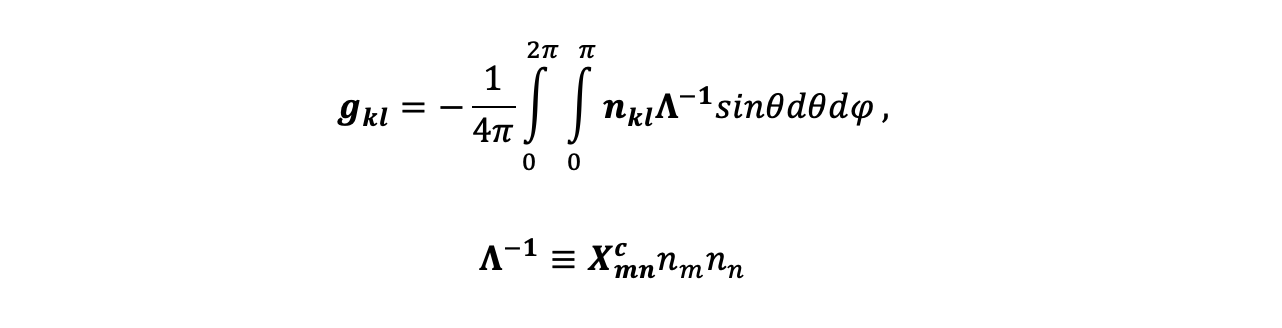

In [ ]:
cv2_imshow(cv2.imread('/content/GSA_2.png'))

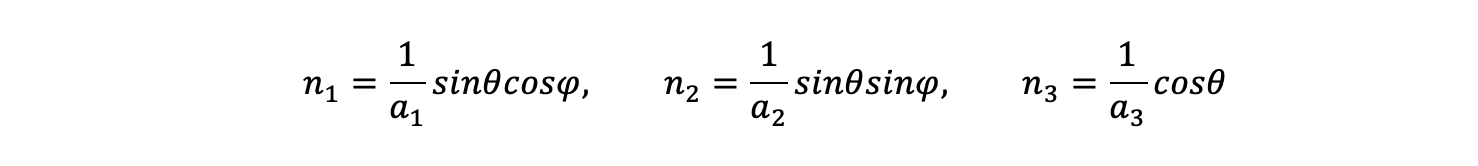

In [ ]:
cv2_imshow(cv2.imread('/content/GSA_3.png'))

Here, $a_1$, $a_2$, and $a_3$ are the semi-axes of ellipsoids describing the shape of the constituent. Usually, in geophysical practice, the shape of the constituent is modeled with $a_1 = a_2 = a$ and $a \geq a_3$ (oblate shape), thus the shape of the constituent is defined as $a_3/a$.


In [20]:
gas_state, brine_state, oil_state = [], [], []

sorted_porosity_list = np.linspace(0, 0.3, 100)

tc_matrix = 2.95
alpha_shape = [1, 0.1, 10**-4]
lam = [tc_matrix, 0.025, 0.025]
crack_porosity = 0.03

for porosity in sorted_porosity_list:
  if porosity == 0:
    crack_porosity = 0
    conc = [1-porosity, porosity-crack_porosity, crack_porosity]
    gas_state.append(effective_tc(conc, alpha_shape, lam))
  else:
    conc = [1-porosity, porosity-crack_porosity, crack_porosity]
    gas_state.append(effective_tc(conc, alpha_shape, lam))

lam = [tc_matrix, 0.60, 0.025]
for porosity in sorted_porosity_list:
  if porosity == 0:
    crack_porosity = 0
    conc = [1-porosity, porosity-crack_porosity, crack_porosity]
    brine_state.append(effective_tc(conc, alpha_shape, lam))
  else:
    conc = [1-porosity, porosity-crack_porosity, crack_porosity]
    brine_state.append(effective_tc(conc, alpha_shape, lam))

lam = [tc_matrix, 0.13, 0.025]
for porosity in sorted_porosity_list:
  if porosity == 0:
    crack_porosity = 0
    conc = [1-porosity, porosity-crack_porosity, crack_porosity]
    oil_state.append(effective_tc(conc, alpha_shape, lam))
  else:
    conc = [1-porosity, porosity-crack_porosity, crack_porosity]
    oil_state.append(effective_tc(conc, alpha_shape, lam))

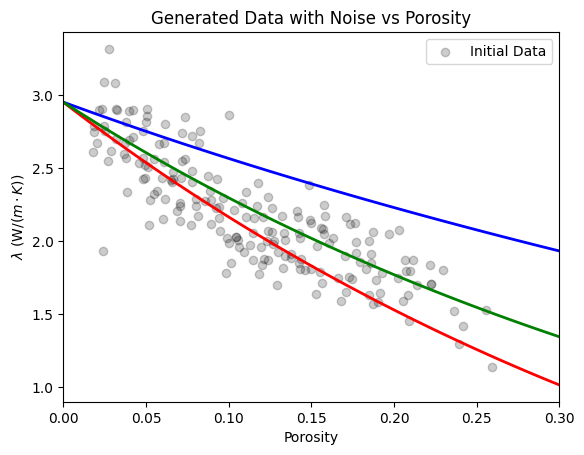

In [21]:
x = new_data['Porosity'].tolist()
y = new_data['TC'].tolist()

plt.scatter(x, y, label='Initial Data', color='black', alpha=0.2)
x = sorted_porosity_list
plt.plot(x, gas_state, color='red', lw=2)
plt.plot(x, brine_state, color='blue', lw=2)
plt.plot(x, oil_state, color='green', lw=2)
plt.xlabel('Porosity')
plt.ylabel('$\lambda$ (W/(${m}\cdot{K}$))')
plt.legend()
plt.title('Generated Data with Noise vs Porosity')
plt.xlim(0, 0.30)
plt.show()

## Elastic wave velocities

In [22]:
def prolate_common(K_i, Mu_i, AR, K_it, Mu_it): ### --> AR>1


    func_teta = (AR * ((AR ** 2-1) ** (-3 / 2))) * (AR * (AR ** 2-1) ** 0.5-np.arccosh(AR))
    func_f = AR ** 2 * (1-AR ** 2) ** -1 * (3 * func_teta-2)


    v_m = (3 * K_it-2 * Mu_it) / (6 * K_it+2 * Mu_it) ### < -- Poisson ration
    R = (1 - 2*v_m) / (2 *(1-v_m))

    A = Mu_i / Mu_it - 1
    B = 1/3 * ((K_i / K_it)-(Mu_i / Mu_it))

    F1 = 1+A * (1.5 * (func_f+func_teta)-R * (1.5 * func_f+2.5 * func_teta-4 / 3))
    F2 = 1+A * (1+1.5 * (func_f+func_teta)-0.5 * R * (3 * func_f+5 * func_teta))+ \
           B * (3-4 * R)+0.5 * A * (A+3 * B) * (3-4 * R) * (
                   func_f+func_teta-R * (func_f-func_teta+2 * func_teta ** 2))
    F3 = 1+A * (1-(func_f+1.5 * func_teta)+R * (func_f+func_teta))
    F4 = 1+0.25 * A * (func_f+3 * func_teta-R * (func_f-func_teta))
    F5 = A * (-func_f+R * (func_f+func_teta-4 / 3))+B * func_teta * (3-4 * R)
    F6 = 1+A * (1+func_f-R * (func_f+func_teta))+B * (1-func_teta) * (3-4 * R)
    F7 = 2+0.25 * A * (3 * func_f+9 * func_teta-R * (3 * func_f+5 * func_teta))+B * func_teta * (3-4 * R)
    F8 = A * (1-2 * R+0.5 * func_f * (R-1)+0.5 * func_teta * (5 * R-3))+B * (1-func_teta) * (3-4 * R)
    F9 = A * ((R-1) * func_f-R * func_teta)+B * func_teta * (3-4 * R)


    P = 1/3 * (3*F1 / F2)
    Q = 1 / 5 * (2 / F3+1 / F4+((F4 * F5+F6 * F7-F8 * F9) / (F2 * F4)))

    return P, Q


def oblate_common(K_i, Mu_i, AR, K_it, Mu_it): ### < --- oblate - AR < 1
                                              ### <-- K_i, Mu_i: components of medium
                                              ### <-- K_it, Mu_it: effective moduls, that iterate

    func_teta = AR / ((1-AR ** 2) ** (3/2)) * (np.arccos(AR) - AR * (1-AR ** 2) ** 0.5)
    func_f = (AR ** 2 / (1-AR ** 2)) * (3 * func_teta-2)

    v_m = (3 * K_it-2 * Mu_it) / (6 * K_it + 2 * Mu_it)
    R = (1-2 * v_m) / (2 * (1-v_m))

    A = (Mu_i / Mu_it)-1
    B = 1 / 3 * ((K_i / K_it)-(Mu_i / Mu_it))

    F1 = 1+A * (1.5 * (func_f+func_teta)-R * (1.5 * func_f+2.5 * func_teta-4 / 3))
    F2 = 1+A * (1+1.5 * (func_f+func_teta)-0.5 * R * (3 * func_f+5 * func_teta))+ \
           B * (3-4 * R)+0.5 * A * (A+3 * B) * (3-4 * R) * (func_f+func_teta-R * (func_f-func_teta+2 * func_teta ** 2))
    F3 = 1+A * (1-(func_f+1.5 * func_teta)+R * (func_f+func_teta))
    F4 = 1+0.25 * A * (func_f+3 * func_teta-R * (func_f-func_teta))
    F5 = A * (-func_f+R * (func_f+func_teta-4 / 3))+B * func_teta * (3-4 * R)
    F6 = 1+A * (1+func_f-R * (func_f+func_teta))+B * (1-func_teta) * (3-4 * R)
    F7 = 2+0.25 * A * (3 * func_f+9 * func_teta-R * (3 * func_f+5 * func_teta))+B * func_teta * (3-4 * R)
    F8 = A * (1-2 * R+0.5 * func_f * (R-1)+0.5 * func_teta * (5 * R-3))+B * (1-func_teta) * (3-4 * R)
    F9 = A * ((R-1) * func_f-R * func_teta)+B * func_teta * (3-4 * R)

    P = 1/3 * (3*F1/F2)
    Q = 1/5 * (2/F3 + 1/F4 + ((F4 * F5 + F6 * F7 - F8 * F9) / (F2 * F4)))

    return P, Q

In [23]:
def effective_modulus(AR_mtrx, AR_fluid, K_it, Mu_it, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por):

  P_mtrx, Q_mtrx = 0, 0
  P_fl, Q_fl = 0, 0

  if AR_mtrx < 1:
    P_mtrx, Q_mtrx = oblate_common(K_matrix, Mu_matrix, AR_mtrx, K_it, Mu_it)
  elif AR_mtrx == 1:
    AR_mtrx = 1.00001
    P_mtrx, Q_mtrx = prolate_common(K_matrix, Mu_matrix, AR_mtrx, K_it, Mu_it)
  else:
     P_mtrx, Q_mtrx = prolate_common(K_matrix, Mu_matrix, AR_mtrx, K_it, Mu_it)


  if AR_fluid < 1:
    P_fl, Q_fl = oblate_common(K_fluid, Mu_fluid, AR_fluid, K_it, Mu_it)
  elif AR_fluid == 1:
    AR_fluid = 1.00001
    P_fl, Q_fl = prolate_common(K_fluid, Mu_fluid, AR_fluid, K_it, Mu_it)
  else:
    P_fl, Q_fl = prolate_common(K_fluid, Mu_fluid, AR_fluid, K_it, Mu_it)



  Mu = (((1-por) * Mu_matrix * Q_mtrx)+(por * Mu_fluid * Q_fl)) / (
            (1-por) * Q_mtrx + por * Q_fl)  # эффективный модуль сдвига


  K = (((1-por) * K_matrix * P_mtrx)+(por * K_fluid * P_fl)) / (
            (1-por) * P_mtrx + por * P_fl)  # эффективный модуль сжатия


  return K, Mu

In [24]:
def main_Berryman_common(AR_mtrx, AR_fluid, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por):

  K, Mu = 0, 0

  x0, x1 = K_matrix, Mu_matrix ### <--- first initialization
  K_eff, Mu_eff = effective_modulus(AR_mtrx, AR_fluid, x0, x1, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por)


  while abs(x0-K_eff) and abs(x1-Mu_eff) >= eps:
    # print(x0, x1, K_eff, Mu_eff)
    x0, x1 = K_eff, Mu_eff
    K_eff, Mu_eff = effective_modulus(AR_mtrx, AR_fluid, x0, x1, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por)

  K, Mu = K_eff, Mu_eff

  return K, Mu

In [25]:
def velosity2modulus(density, Vp, Vs): ### <-- K, mu to Vp, Vs

    с_11 = Vp**2*density
    c_44 = Vs**2*density

    mu = c_44
    K = с_11 - 4/3*mu
    print(с_11,c_44, K, mu)

    return K, mu

In [26]:
def modulus2velosity(density_mtrx, density_fluid, por, K, Mu): ### <-- K, mu to Vp, Vs

    density = density_mtrx * (1-por) + density_fluid * por
    Vp = np.sqrt((K + 4/3*Mu)/ density)
    Vs = np.sqrt(Mu/density)

    return Vp, Vs

In [32]:
Vp_reg_air, Vs_reg_air = 5.77, 3.17
Vp_reg_water, Vs_reg_water = 6.13, 3.25
Vp_reg_oil, Vs_reg_oil = 6.19, 3.39

Vp_reg_water, Vs_reg_water = 5.98, 3.28


K_air_mtrx, Mu_air_mtrx = velosity2modulus(2.71, Vp_reg_air, Vs_reg_air)
K_water_mtrx, Mu_water_mtrx = velosity2modulus(2.71, Vp_reg_water, Vs_reg_water)
K_oil_mtrx, Mu_oil_mtrx = velosity2modulus(2.71, Vp_reg_oil, Vs_reg_oil)


K_water, Mu_water, p_water = 2.25, 10**-20, 1.04
K_air, Mu_air, p_air = 10**-6, 10**-6, 1.22
K_oil, Mu_oil, p_oil = 1, 10**-12, 1.04

density_air, density_water, density_oil = p_air, p_water, p_oil

eps = 10**-4

90.22375899999999 27.232519 53.91373366666666 27.232519
96.910684 29.155263999999995 58.036998666666676 29.155263999999995
103.83663100000001 31.143591 62.31184300000001 31.143591


In [33]:
def table_calclation_elastic(fluid_list, k, mu):

  p_air, p_water, p_oil = 1.22, 1.01, 0.78

  for fluid in fluid_list:

    if fluid=='air':
      density_fluid = p_air
      K_fluid, Mu_fluid = K_air, Mu_air
      ar = 0.09
    elif fluid == 'water':
      density_fluid = p_water
      K_fluid, Mu_fluid = K_water, Mu_water
      ar = 0.13
    elif fluid == 'oil':
      density_fluid = p_oil
      K_fluid, Mu_fluid = K_oil, Mu_oil
      ar = 0.1


    data_fluid = {

    }

    Vp_fluid_list = []
    Vs_fluid_list = []

    globals()[f'result_{fluid}'] = pd.DataFrame(data_fluid)
    globals()[f'sorted_{fluid}'] = pd.DataFrame(data_fluid)


    for porosity, ar_inclusion in zip(np.linspace(0, 0.3, 100), np.linspace(ar, ar, 100)):

      AR_inclusion = ar_inclusion
      AR_mtrx = 1.00001

### Matrix
      # K_matrix, Mu_matrix = globals()[f"K_{fluid}_mtrx"], globals()[f"Mu_{fluid}_mtrx"]
      K_matrix, Mu_matrix = k, mu

      K, Mu = main_Berryman_common(AR_mtrx, AR_inclusion,
                                    K_matrix, Mu_matrix,
                                    K_fluid, Mu_fluid,
                                    porosity)
      density_mtrx = 2.71
      Vp, Vs = modulus2velosity(density_mtrx, density_fluid, porosity, K, Mu)


      Vp_fluid_list.append(Vp)
      Vs_fluid_list.append(Vs)


    globals()[f'result_{fluid}'][f'Porosity,%'] = np.linspace(0, 0.3, 100)
    globals()[f'result_{fluid}'][f'AR inclusion'] = np.linspace(0.1, 0.1, 100)
    globals()[f'result_{fluid}'][f'Vp_{fluid}'] = Vp_fluid_list
    globals()[f'result_{fluid}'][f'Vs_{fluid}'] = Vs_fluid_list

  return globals()[f'sorted_{fluid}'].shape[0]

In [34]:
K,  Mu, porosity = 53.91373366666666, 27.232519, 0
density_mtrx, density_fluid = 2.71, p_water
modulus2velosity(density_mtrx, density_fluid, porosity, K, Mu)

(5.77, 3.17)

In [35]:
fluid_list = ['air', 'water', 'oil']


K_air_mtrx, Mu_air_mtrx = 53.91373366666666, 27.232519
K_water_mtrx, Mu_water_mtrx = 63.66756566666667, 28.624375
K_oil_mtrx, Mu_oil_mtrx = 63.66756566666667, 28.624375

error_air, error_water, error_oil = 0.1, 0.1, 0.1 # Error for K, mu minreal matrix
N = 2

for fluid in fluid_list:

  globals()[f"K_{fluid}_list_mtrx"] = np.linspace(globals()[f"K_{fluid}_mtrx"] - globals()[f"K_{fluid}_mtrx"] * globals()[f"error_{fluid}"],
                                                  globals()[f"K_{fluid}_mtrx"] + globals()[f"K_{fluid}_mtrx"] * globals()[f"error_{fluid}"],
                                                  N)

  globals()[f"Mu_{fluid}_list_mtrx"] = np.linspace(globals()[f"Mu_{fluid}_mtrx"] - globals()[f"Mu_{fluid}_mtrx"] * globals()[f"error_{fluid}"],
                                                   globals()[f"Mu_{fluid}_mtrx"] + globals()[f"Mu_{fluid}_mtrx"] * globals()[f"error_{fluid}"],
                                                   N)

  for k, mu in zip(globals()[f"K_{fluid}_list_mtrx"], globals()[f"Mu_{fluid}_list_mtrx"]):

    number = table_calclation_elastic(fluid_list, k, mu)

In [36]:
vp_array_measured = []
for x in tc_array_new:
    vp = 0.34*x**2 - 0.08*x + 3.24
    vp_array_measured.append(vp)

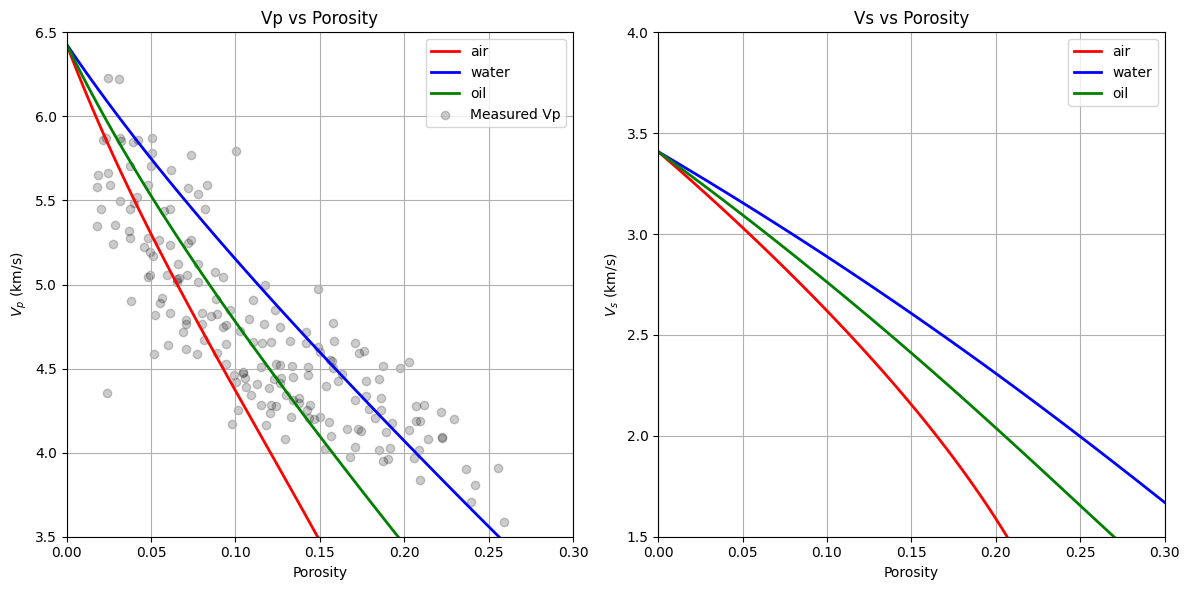

In [37]:
porosity_list = np.linspace(0, 0.3, 100)

fluid_list = ['air', 'water', 'oil']

fluid_colors = {
    'air': 'red',
    'water': 'blue',
    'oil': 'green'
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for fluid in fluid_list:
    ax1.plot(porosity_list, globals()[f'result_{fluid}'][f'Vp_{fluid}'],
             color=fluid_colors[fluid], label=f'{fluid}', lw=2)

x = data['Porosity'].dropna().tolist()
y = vp_array_measured
ax1.scatter(x, y, label='Measured Vp', color='black', alpha=0.2)

ax1.set_xlabel('Porosity')
ax1.set_ylabel('$V_p$ (km/s)')
ax1.set_title('Vp vs Porosity')
ax1.set_xlim(0, 0.30)
ax1.set_ylim(3.5, 6.5)
ax1.legend()
ax1.grid()


for fluid in fluid_list:
    ax2.plot(porosity_list, globals()[f'result_{fluid}'][f'Vs_{fluid}'],
             color=fluid_colors[fluid], label=f'{fluid}', lw=2)

ax2.set_xlabel('Porosity')
ax2.set_ylabel('$V_s$ (km/s)')
ax2.set_title('Vs vs Porosity')
ax2.set_xlim(0, 0.30)
ax2.set_ylim(1.5, 4)
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()